In [5]:
import numpy as np 
import pandas as pd 
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

print(tf.__version__)

2.11.0


In [6]:
SIZE = 128
batch_size = 64

In [7]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    '/kaggle/input/malaria-cell-imagesshuffled-and-split/train',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

validation_generator = datagen.flow_from_directory(
    '/kaggle/input/malaria-cell-imagesshuffled-and-split/val',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

anomaly_generator = datagen.flow_from_directory(
    '/kaggle/input/malaria-cell-imagesshuffled-and-split/val/Parasitized',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )


Found 20668 images belonging to 2 classes.
Found 6890 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


In [8]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

#Decoder
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

In [9]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 16)       0

In [14]:
history = model.fit(
        train_generator,
        steps_per_epoch= 500 // batch_size,
        epochs=500,
        verbose=0,
        validation_data=validation_generator,
        validation_steps=75 // batch_size,
        shuffle = True)

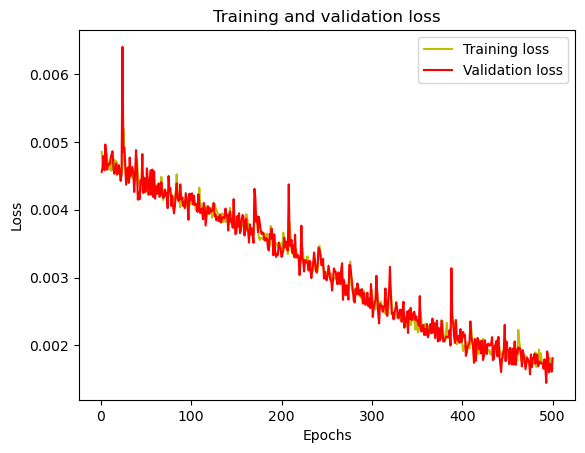

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [16]:
# Get all batches generated by the datagen and pick a batch for prediction
#Just to test the model. 
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
    data = train_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1

predicted = model.predict(data_batch[0])  #Predict on the first batch of images


2/2 [==============================] - 1s 8ms/step


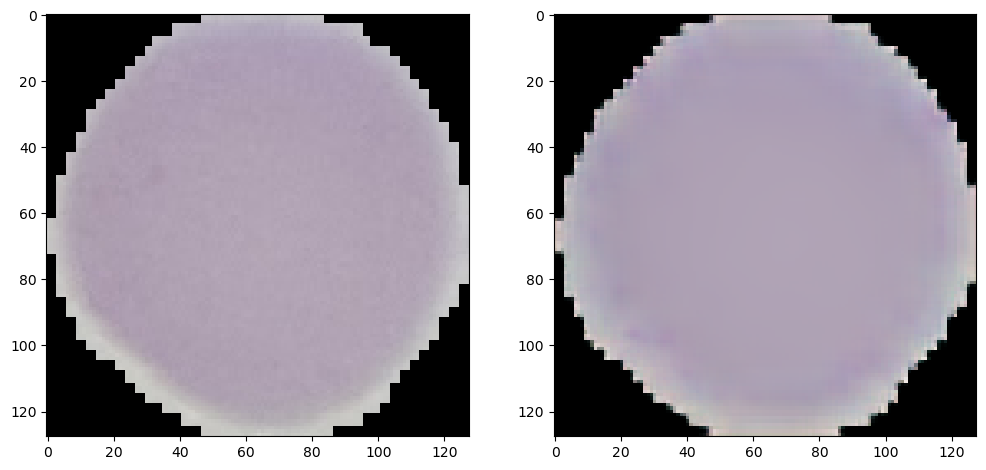

In [17]:
#Sanity check, view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()

In [19]:
#Let us extract (or build) the encoder network, with trained weights.
#This is used to get the compressed output (latent space) of the input image. 
#The compressed output is then used to calculate the KDE

encoder_model = Sequential()
encoder_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3), weights=model.layers[0].get_weights()) )
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', weights=model.layers[2].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', weights=model.layers[4].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 16)      

In [21]:
# Calculate KDE using sklearn
from sklearn.neighbors import KernelDensity

#Get encoded output of input images = Latent space
encoded_images = encoder_model.predict(train_generator)

323/323 [==============================] - 52s 160ms/step


In [22]:
# Flatten the encoder output because KDE from sklearn takes 1D vectors as input
encoder_output_shape = encoder_model.output_shape #Here, we have 16x16x16
out_vector_shape = encoder_output_shape[1]*encoder_output_shape[2]*encoder_output_shape[3]

encoded_images_vector = [np.reshape(img, (out_vector_shape)) for img in encoded_images]

#Fit KDE to the image latent data
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)

In [24]:
#Calculate density and reconstruction error to find their means values for
#good and anomaly images. 
#We use these mean and sigma to set thresholds. 
def calc_density_and_recon_error(batch_images):
    
    density_list=[]
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]-1):
        
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        encoded_img = encoder_model.predict([[img]]) # Create a compressed version of the image using the encoder
        encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] # Flatten the compressed image
        density = kde.score_samples(encoded_img)[0] # get a density score for the new image
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
        density_list.append(density)
        recon_error_list.append(reconstruction_error)
        
    average_density = np.mean(np.array(density_list))  
    stdev_density = np.std(np.array(density_list)) 
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list)) 
    
    return average_density, stdev_density, average_recon_error, stdev_recon_error


In [26]:
#Get average and std dev. of density and recon. error for uninfected and anomaly (parasited) images. 
#For this let us generate a batch of images for each. 
train_batch = train_generator.next()[0]
anomaly_batch = anomaly_generator.next()[0]

uninfected_values = calc_density_and_recon_error(train_batch)
anomaly_values = calc_density_and_recon_error(anomaly_batch)

1/1 [==============================] - 0s 28ms/step - loss: 0.0020 - mse: 0.0020


/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [27]:
#Now, input unknown images and sort as Good or Anomaly
def check_anomaly(img_path):
    density_threshold = 2500 #Set this value based on the above exercise
    reconstruction_error_threshold = 0.004 # Set this value based on the above exercise
    img  = Image.open(img_path)
    img = np.array(img.resize((128,128), Image.ANTIALIAS))
    plt.imshow(img)
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    encoded_img = encoder_model.predict([[img]]) 
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] 
    density = kde.score_samples(encoded_img)[0] 

    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]

    if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
        print("The image is an anomaly")
        
    else:
        print("The image is NOT an anomaly")

1/1 [==============================] - 0s 26ms/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  


1/1 [==============================] - 0s 29ms/step - loss: 0.0033 - mse: 0.0033
The image is NOT an anomaly
1/1 [==============================] - 0s 24ms/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  


1/1 [==============================] - 0s 30ms/step - loss: 0.0017 - mse: 0.0017
The image is an anomaly


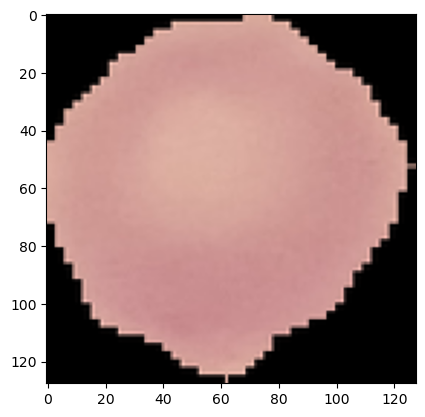

In [35]:
#Load a couple of test images and verify whether they are reported as anomalies.
import glob
para_file_paths = glob.glob('/kaggle/input/malaria-cell-imagesshuffled-and-split/val/Parasitized/*')
uninfected_file_paths = glob.glob('/kaggle/input/malaria-cell-imagesshuffled-and-split/val/Uninfected/*')

#Anomaly image verification
num=random.randint(0,len(para_file_paths)-1)
check_anomaly(para_file_paths[num])

#Good/normal image verification
num=random.randint(0,len(para_file_paths)-1)
check_anomaly(uninfected_file_paths[num])

1/1 [==============================] - 0s 26ms/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  


1/1 [==============================] - 0s 33ms/step - loss: 0.0026 - mse: 0.0026
The image is NOT an anomaly
1/1 [==============================] - 0s 33ms/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  


1/1 [==============================] - 0s 29ms/step - loss: 0.0015 - mse: 0.0015
The image is NOT an anomaly


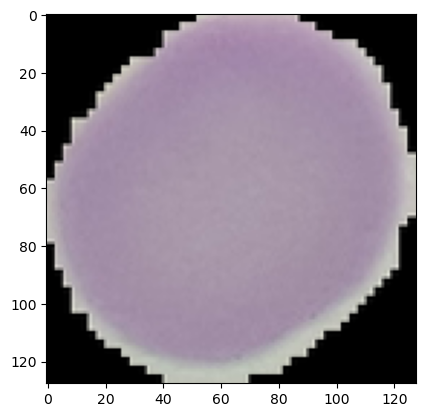

In [36]:
#Load a couple of test images and verify whether they are reported as anomalies.
import glob
para_file_paths = glob.glob('/kaggle/input/malaria-cell-imagesshuffled-and-split/val/Parasitized/*')
uninfected_file_paths = glob.glob('/kaggle/input/malaria-cell-imagesshuffled-and-split/val/Uninfected/*')

#Anomaly image verification
num=random.randint(0,len(para_file_paths)-1)
check_anomaly(para_file_paths[num])

#Good/normal image verification
num=random.randint(0,len(para_file_paths)-1)
check_anomaly(uninfected_file_paths[num])

1/1 [==============================] - 0s 27ms/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  


1/1 [==============================] - 0s 29ms/step - loss: 0.0039 - mse: 0.0039
The image is NOT an anomaly
1/1 [==============================] - 0s 34ms/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  


1/1 [==============================] - 0s 30ms/step - loss: 0.0023 - mse: 0.0023
The image is NOT an anomaly


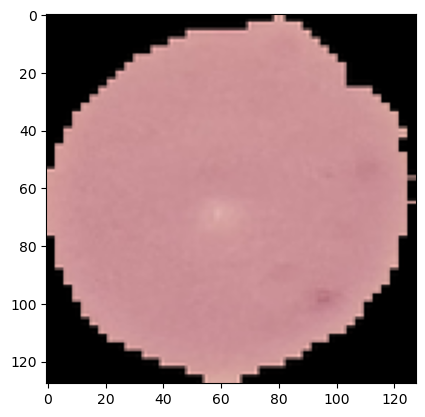

In [37]:
#Load a couple of test images and verify whether they are reported as anomalies.
import glob
para_file_paths = glob.glob('/kaggle/input/malaria-cell-imagesshuffled-and-split/val/Parasitized/*')
uninfected_file_paths = glob.glob('/kaggle/input/malaria-cell-imagesshuffled-and-split/val/Uninfected/*')

#Anomaly image verification
num=random.randint(0,len(para_file_paths)-1)
check_anomaly(para_file_paths[num])

#Good/normal image verification
num=random.randint(0,len(para_file_paths)-1)
check_anomaly(uninfected_file_paths[num])